In [52]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE


"""import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import catboost as catb"""
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [53]:
import warnings
warnings.simplefilter('ignore')

Пути к файлам

In [54]:
train_dummies_prep = 'train_dummies_prepared.csv'
test_dummies_prep = 'test_dummies_prepared.csv'

train_prep = 'train_prepared.csv'
test_prep = 'test_prepared.csv'

train_dummies = 'train_dummies.csv'
test_dummies = 'test_dummies.csv'

Функции

In [55]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
    
def visual_bar(feature_1):
    pd.crosstab(train_df[feature_1],train_df['Credit Default']).plot(kind='bar')
    plt.xlabel(feature_1)
    plt.ylabel('Credit Default')
    plt.show()

Читаем файлы

In [56]:
train_base = pd.read_csv(train_dummies)
test_base = pd.read_csv(test_dummies)

Для предикта

In [73]:
pred_df = test_base.copy()

# Анализ переменных

In [58]:
train_df.groupby('Credit Default').mean()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
Credit Default,,,,,,,,,,,,,,,,,,,,,
0,0.063082,-0.010586,-0.021251,-0.028942,0.008925,0.039936,-0.012260,0.004494,-0.123560,-0.050329,...,0.001312,0.050630,0.006558,0.008919,0.001574,0.088143,0.002361,0.005509,0.001312,0.001574
1,-0.130618,0.021920,0.044003,0.059928,-0.018480,-0.082691,0.025386,-0.009306,0.255845,0.104213,...,0.000543,0.052146,0.003802,0.011407,0.001086,0.097230,0.007061,0.004889,0.001086,0.001086


Очень похожие значения, плохо

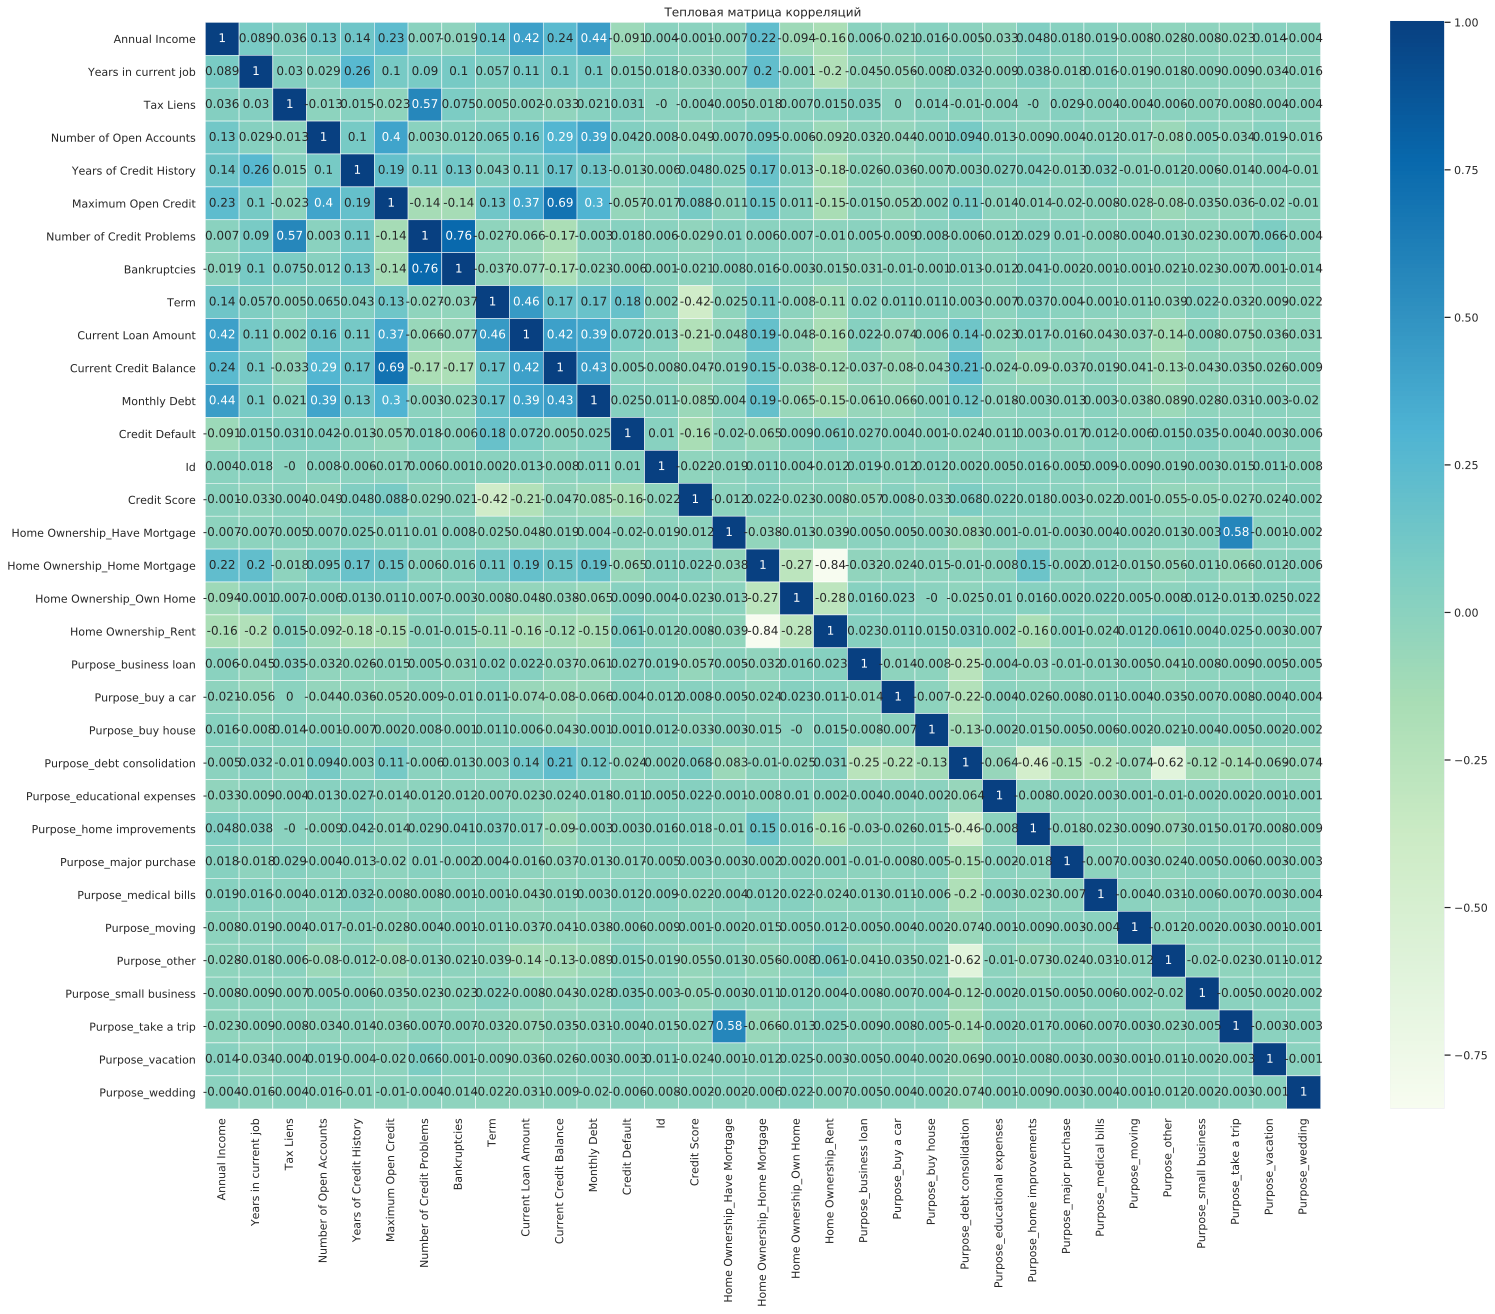

In [59]:
plt.figure(figsize = (25,20))
sns.set(font_scale=1.0)
sns.heatmap(train_df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Тепловая матрица корреляций')
plt.show()

Разделение признаков

In [60]:
train_df.columns.tolist()

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Default',
 'Id',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

In [61]:
NUM_FEATURES = ['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

CAT_FEATURES = ['Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

SELECTED_FEATURES = NUM_FEATURES + CAT_FEATURES

In [62]:
df = train_df[SELECTED_FEATURES]

Определим целевую переменную

In [63]:
TARGET_NAME = 'Credit Default'

Стандартизация признаков

In [64]:
scaler = StandardScaler()

train_scaled = train_base.copy()
train_scaled[NUM_FEATURES] = scaler.fit_transform(train_scaled[NUM_FEATURES])

train_df = train_scaled.copy()

Балансировка таргета + разбиение на трейн и тест по SMOTE

In [65]:
X =train_df[SELECTED_FEATURES]
y = train_df[TARGET_NAME]

oversamp = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_X,os_y = oversamp.fit_sample(X_train, y_train)

os_X = pd.DataFrame(data=os_X,columns=columns)

os_y = pd.DataFrame(data=os_y,columns=[TARGET_NAME])

print("Длина раздутых данных ",len(os_X))
print("Кредитный дефолт 0: ",len(os_y[os_y[TARGET_NAME]==0]))
print("Кредитный дефолт 1: ",len(os_y[os_y[TARGET_NAME]==1]))
print("Доля данных с погашенным кредитом: ",len(os_y[os_y[TARGET_NAME]==0])/len(os_X))
print("Доля даных с фактом дефолта по кредиту: ",len(os_y[os_y[TARGET_NAME]==1])/len(os_X))

Длина раздутых данных  5310
Кредитный дефолт 0:  2655
Кредитный дефолт 1:  2655
Доля данных с погашенным кредитом:  0.5
Доля даных с фактом дефолта по кредиту:  0.5


Рекурсивное утранение(отбор) признаков

In [66]:
from sklearn.feature_selection import RFE

df_vars=train_df[SELECTED_FEATURES].columns.values.tolist()
y=[TARGET_NAME]
X=[i for i in df_vars if i not in y]

lgr = LogisticRegression()

rfe = RFE(lgr, 20)
rfe = rfe.fit(os_X, os_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(df_vars)

[ True False False False False False False False  True False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[ 1  6  8  5 12  3 11 10  1  2  4  7  9  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1]
['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation', 'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving', 'Purpose_other', 'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding']


Смотрим на значения признаков по RFE и сопоставляем с нашими признаками, в результате имеем набор самых лучших признаков по алгоритму рекурсивного отбора

In [67]:
IMP_FEATURES = ['Annual Income','Term','Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 
                'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_business loan', 
                'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation', 
                'Purpose_educational expenses', 'Purpose_home improvements', 'Purpose_major purchase', 
                'Purpose_medical bills', 'Purpose_moving', 'Purpose_other', 'Purpose_small business', 
                'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding']


X=os_X[IMP_FEATURES]
y=os_y[TARGET_NAME]

Реализация модели

In [68]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.659192
         Iterations: 35
                                   Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.049     
Dependent Variable:         Credit Default         AIC:                    7040.6171 
Date:                       2020-10-30 15:16       BIC:                    7172.1640 
No. Observations:           5310                   Log-Likelihood:         -3500.3   
Df Model:                   19                     LL-Null:                -3680.6   
Df Residuals:               5290                   LLR p-value:            6.5414e-65
Converged:                  0.0000                 Scale:                  1.0000    
No. Iterations:             35.0000                                                  
-------------------------------------------------------------------------------------
                              Coef.    Std.Err.    z    P>|z|     [0.025     0.975]  
------------------------

Тут смотри на p-value и убираем признаки, значения p-value котрых > 0,05

In [69]:
IMP_FEATURES = ['Annual Income','Term', 
                'Home Ownership_Own Home', 'Home Ownership_Rent',  
                'Purpose_buy a car', 'Purpose_debt consolidation', 
                 'Purpose_home improvements', 'Purpose_major purchase', 
                'Purpose_medical bills', 'Purpose_other']


X=os_X[IMP_FEATURES]
y=os_y[TARGET_NAME]


logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.660906
         Iterations 5
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.047     
Dependent Variable:    Credit Default      AIC:                 7038.8179 
Date:                  2020-10-30 15:18    BIC:                 7104.5914 
No. Observations:      5310                Log-Likelihood:      -3509.4   
Df Model:              9                   LL-Null:             -3680.6   
Df Residuals:          5300                LLR p-value:         2.5599e-68
Converged:             1.0000              Scale:               1.0000    
No. Iterations:        5.0000                                             
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Annual Income              -

In [70]:
"""IMP_FEATURES = ['Annual Income','Number of Open Accounts', 
                'Maximum Open Credit',
                'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent',
                'Purpose_buy a car','Purpose_debt consolidation','Purpose_home improvements',
                'Purpose_medical bills','Purpose_other']


X=os_X[IMP_FEATURES]
y=os_y[TARGET_NAME]


logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())"""

"IMP_FEATURES = ['Annual Income','Number of Open Accounts', \n                'Maximum Open Credit',\n                'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',\n                'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent',\n                'Purpose_buy a car','Purpose_debt consolidation','Purpose_home improvements',\n                'Purpose_medical bills','Purpose_other']\n\n\nX=os_X[IMP_FEATURES]\ny=os_y[TARGET_NAME]\n\n\nlogit_model=sm.Logit(y,X)\nresult=logit_model.fit()\nprint(result.summary2())"

Подгонка модели логистической регрессии

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Прогнозирование руз-ов тестового(X_test) набора

In [72]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.68      0.64      1867
           1       0.62      0.54      0.58      1850

    accuracy                           0.61      3717
   macro avg       0.61      0.61      0.61      3717
weighted avg       0.61      0.61      0.61      3717

TEST

              precision    recall  f1-score   support

           0       0.62      0.70      0.65       788
           1       0.66      0.58      0.61       805

    accuracy                           0.63      1593
   macro avg       0.64      0.64      0.63      1593
weighted avg       0.64      0.63      0.63      1593

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               548  240
1               342  463


Видно, что ошибка очень высока(

### TEST PREDICTIONS

In [74]:
test_base

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1068303.5,4,0.0,9.0,12.5,220968.0,0.0,0.0,0,162470.0,...,0,0,0,0,0,0,0,0,0,0
1,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.0,0,78298.0,...,1,0,0,0,0,0,0,0,0,0
2,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0,200178.0,...,0,0,0,0,0,0,0,0,0,0
3,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,0.0,0,217382.0,...,0,0,0,0,0,0,0,0,0,0
4,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,1,777634.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.0,10,0.0,14.0,29.1,559152.0,1.0,1.0,0,322366.0,...,0,0,0,0,0,0,0,0,0,0
2496,1068303.5,2,0.0,15.0,17.0,1737780.0,0.0,0.0,0,468512.0,...,0,0,0,0,0,0,0,0,0,0
2497,1171806.0,2,0.0,48.0,12.8,1706430.0,0.0,0.0,0,430496.0,...,0,0,0,0,0,0,0,0,0,0
2498,723520.0,10,0.0,14.0,28.8,945780.0,0.0,0.0,0,257774.0,...,0,0,0,0,0,0,0,0,0,0


Стандартизация признаков

In [76]:
scaler = StandardScaler()

test_scaled = test_base.copy()
test_scaled[NUM_FEATURES] = scaler.fit_transform(test_scaled[NUM_FEATURES])

test_df = test_scaled.copy()

In [78]:
test_df[IMP_FEATURES]

,Annual Income,Term,Home Ownership_Own Home,Home Ownership_Rent,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_other
0,-0.274101,-0.585973,0,1,0,1,0,0,0,0
1,-2.012357,-0.585973,0,1,0,0,0,0,0,0
2,-0.099050,-0.585973,0,0,0,1,0,0,0,0
3,0.041789,-0.585973,0,0,0,1,0,0,0,0
4,2.370585,1.706565,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2495,-0.374370,-0.585973,0,0,0,1,0,0,0,0
2496,-0.274101,-0.585973,0,0,0,1,0,0,0,0
2497,-0.059013,-0.585973,0,0,0,1,0,0,0,0
2498,-0.990594,-0.585973,0,1,0,1,0,0,0,0


In [81]:
prediction = logreg.predict(test_df[IMP_FEATURES])

In [83]:
pred_df[TARGET_NAME] = prediction

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   int64  
 2   Tax Liens                     2500 non-null   float64
 3   Number of Open Accounts       2500 non-null   float64
 4   Years of Credit History       2500 non-null   float64
 5   Maximum Open Credit           2500 non-null   float64
 6   Number of Credit Problems     2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Term                          2500 non-null   int64  
 9   Current Loan Amount           2500 non-null   float64
 10  Current Credit Balance        2500 non-null   float64
 11  Monthly Debt                  2500 non-null   float64
 12  Id                            2500 non-null   int64  
 13  Cre

In [84]:
pred_df[['Id', TARGET_NAME]].to_csv('Kochetkov_MD_predictions_lgr.csv', index=False)

In [85]:
df_2 = pd.read_csv('Kochetkov_MD_predictions_lgr.csv')
df_2

,Id,Credit Default
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,1
